In [58]:
import os
from dotenv import load_dotenv
import snowflake.connector
import pandas as pd
import plotly.express as px
# Use Plotly's "make_subplots" function from "plotly.subplots" to layout elements horizontally
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Load credentials
load_dotenv()

# Set the display environment
pd.set_option('display.width', 1500)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)


In [31]:
# Connect to Snowflake
conn = snowflake.connector.connect(
    user=os.getenv('SNOWFLAKE_USER'),
    password=os.getenv('SNOWFLAKE_PASSWORD'),
    account=os.getenv('SNOWFLAKE_ACCOUNT') + '.' + os.getenv('SNOWFLAKE_REGION'),
    warehouse=os.getenv('SNOWFLAKE_WAREHOUSE'),
    database='WALMART_DB',
    schema='SILVER',
    role=os.getenv('SNOWFLAKE_ROLE')
)

In [38]:
# SQL query
sql = """
SELECT
    dept_id,
    sum(store_weekly_sales) as weekly_sales
FROM
    WALMART_FACT_TABLE
GROUP BY
    dept_id
ORDER BY
    dept_id
"""

# Run query using Snowflake connector
cur = conn.cursor()
cur.execute(sql)

# Load results into DataFrame
columns = [col[0] for col in cur.description]

# Get all the data at once
data = cur.fetchall()
df = pd.DataFrame(data, columns=columns)

# Force column names to lowercase so Snowflake will match the model table
df.columns = [col.lower() for col in df.columns]

# print(df.columns)


In [4]:
print(f"${1234567.8912:,.2f}")

$1,234,567.89


In [26]:
s = ['A', 'B', 'C']
print (s[::-1])

['C', 'B', 'A']


In [43]:
# Create the total row
total_weekly_sales = df.iloc[:, 1].sum(numeric_only=True)
print(total_weekly_sales)

# Create a list that can be appended to the dataframe.
df_total_row = pd.DataFrame([['Total', total_weekly_sales]], columns=['dept_id','weekly_sales'])
print(df_total_row)

df_test = pd.concat([df,df_total_row], ignore_index=True)
# print(df_test)
# print("--------")
# print(df)



6737218987.110001
  dept_id  weekly_sales
0   Total  6.737219e+09


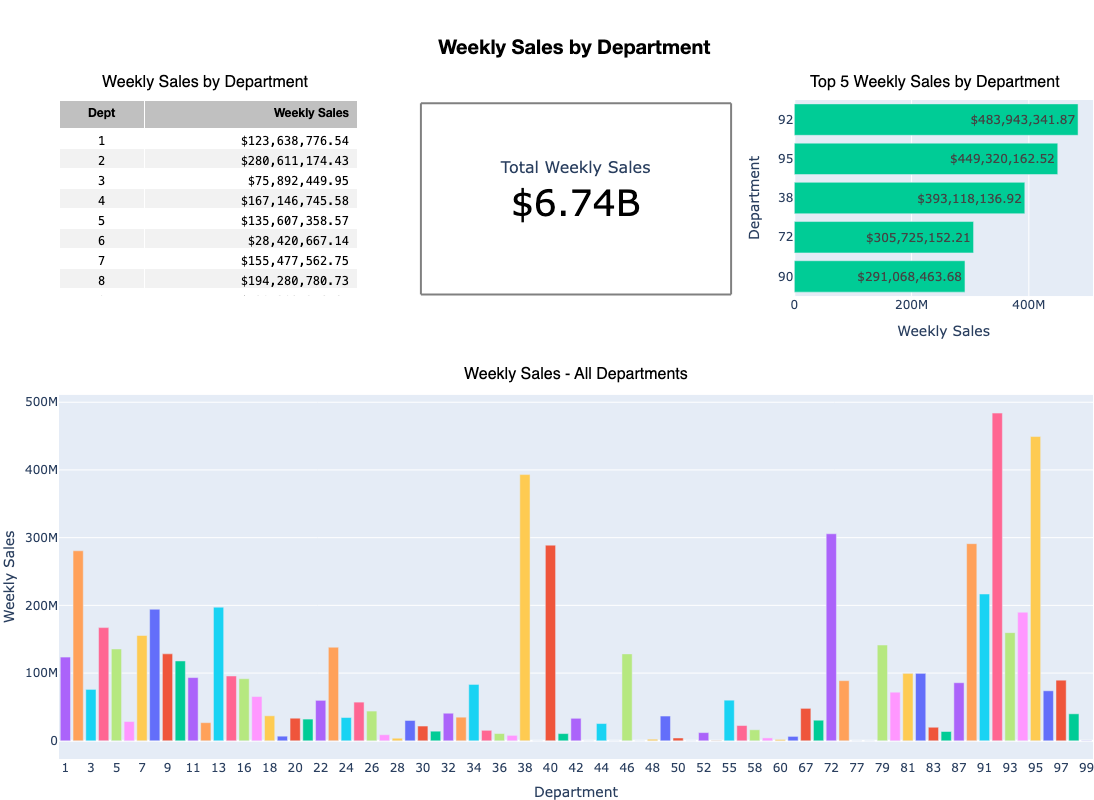

In [146]:
# Create a dashboard for the charts

# First, let's layout the overall container for the charts
fig = make_subplots(
    rows=2,
    cols=3,
    specs=[
        [{'type':"indicator"}, {'type':"indicator", 't':0.08, 'b':0}, {'type':"xy"}],
        [{"type": "xy", 't':0, 'b':0, 'colspan': 3}, None, None]
    ],
    shared_xaxes = False,
    # horizontal_spacing = 0.12,  # The space between the rows
    column_widths = [3, 3, 3],
    row_heights = [0.35, 0.65]
)

# ===============================

def formatSales(value):
    if value >= 1_000_000_000:
        return f"${value / 1_000_000_000:.2f}B"
    elif value >= 1_000_000:
        return f"${value / 1_000_000:.2f}M"
    elif value >= 1_000:
        return f"${value / 1_000:.2f}K"
    else:
        return f"${value:2f}"
        
# ===============================

# Table - Weekly sales by department

# Add a total row for the weekly sales
# Create the total row
total_weekly_sales = df.iloc[:, 1].sum(numeric_only=True)
# print(total_weekly_sales)

# Create a list that can be appended to the dataframe.
df_total_row = pd.DataFrame([['Total', total_weekly_sales]], columns=['dept_id','weekly_sales'])
# print(df_total_row)

df_raw_with_total = pd.concat([df,df_total_row], ignore_index=True)
# print(df_raw_with_total)

# Make a copy to format the numbers
df_fmt = df_raw_with_total.copy()

# Format the numbers
for col in df_fmt.columns[1:]:
    df_fmt[col] = df_fmt[col].apply(lambda x: f"${x:,.2f}")

# Format the table with zebra striping
# Alternate row colors: white for even, light gray for odd.
# We build color lists for each column, with the last row (the total row) as white.
fill_colors = [
    ['white' if i % 2 == 0 else '#f2f2f2' for i in range(len(df_fmt.index) - 1)] + ['white']
    for _ in range(len(df_fmt))
]

# Overwrite the final row (the Total row) to a distinct color for emphasis as well
for i in range(len(fill_colors)):
    fill_colors[i][-1] = 'lavender'

# Now add a bold tag to the total row.  Loop through each column in the last row
# and surround it with the <b></b> tags. Don't be confused by the statement:
# df_weekly_sales.iloc[-1][col]
# This is chaining 2 statements together to fetch the last row first (as a series), then
# fetching the label-based element associated with the variable "col" to get the specific
# element.
for col in df_fmt.columns:
    df_fmt.loc[len(df_fmt)-1, col] = f"<b>{df_fmt.iloc[-1][col]}</b>"

# Format the header values
column_map = {
    'dept_id': 'Dept',
    'weekly_sales': 'Weekly Sales'
}

formatted_headers = [column_map[col] for col in df_fmt.columns]

# Gather the cell values
cell_values = [df_fmt[col] for col in df_fmt.columns]

weekly_sales_by_dept_indicator = go.Table(
    columnwidth=[10,25],
    header = dict(
        values = formatted_headers,
        fill_color = '#C0C0C0',
        align = ['center','right'],
        font = dict(size=12,family="Helvetica Neue", color='black', weight='bold'),
    ),
    cells = dict(
        values = cell_values,
        align = ['center','right'],
        fill_color = fill_colors,
        font = dict(size=12, family="Menlo", color='black')
    )
)

fig.add_trace(weekly_sales_by_dept_indicator, row=1, col=1)

# Add a nice header to the cell
fig.add_annotation(
    text = "Weekly Sales by Department",
    x = 0.04,  # roughly center of line chart
    y = 1.045,  # above the line chart
    xref = "paper",
    yref = "paper",
    showarrow = False,
    font = dict(size=16, family="Helvetica", color="black")
)


# ===============================

# Total Weekly Sales Indicator
# totalWeeklySales = df['weekly_sales'].sum()
totalWeeklySales = df_raw_with_total.iloc[-1,-1]
totalWeeklySalesFormattedStr = formatSales(totalWeeklySales)

weekly_sales_indicator = go.Table(
    header = dict(
        values = ["Total Weekly Sales"],
        fill_color = 'white',
        align = 'center',
        font = dict(size=16)
    ),
    cells = dict (
        values = [[totalWeeklySalesFormattedStr]],
        align = 'center',
        fill_color = 'white',
        font = dict(size=36, color='black')
    )
)

fig.add_trace(weekly_sales_indicator, row=1, col=2)

# Add a box around the total value to define space
# Top
fig.add_shape(
    type="line",
    x0=0.35, x1=0.65,
    y0=0.995, y1=0.995,
    xref="paper", yref="paper",
    line=dict(color="grey", width=2),
    layer="below"
)
# Bottom
fig.add_shape(
    type="line",
    x0=0.35, x1=0.65,
    y0=0.705, y1=0.705,
    xref="paper", yref="paper",
    line=dict(color="grey", width=2),
    layer="below"
)
# Left
fig.add_shape(
    type="line",
    x0=0.35, x1=0.35,
    y0=0.705, y1=0.995,
    xref="paper", yref="paper",
    line=dict(color="grey", width=2),
    layer="below"
)
# Right
fig.add_shape(
    type="line",
    x0=0.65, x1=0.65,
    y0=0.705, y1=0.995,
    xref="paper", yref="paper",
    line=dict(color="grey", width=2),
    layer="below"
)

# ===============================

# Top 5 Departments from Sales
# Copy the raw sales data to sort it
df_top5_sales = df.sort_values(by='weekly_sales', ascending=False).reset_index(drop=True)
df_top5_sales = df_top5_sales.head(5)

# Rename the columns for presentation
renamed_columns = {'dept_id':'Department', 'weekly_sales':'Weekly Sales'}
df_top5_sales = df_top5_sales.rename(columns=renamed_columns)

# Reverse the order of the dataframe so Plotly will show the largest value at the top
df_top5_sales = df_top5_sales[::-1]

# Convert the department values to strings to make Plotly treat them as categories instead of numbers
df_top5_sales['Department'] = df_top5_sales['Department'].astype(str)

top5_sales_trace = go.Bar(
    x=df_top5_sales['Weekly Sales'],
    y=df_top5_sales['Department'],
    orientation='h',
    text=df_top5_sales['Weekly Sales'].map("${:,.2f}".format),
    textposition='inside',
    hovertemplate='Dept: %{y}<br>Sales: %{x:$,.2f}<extra></extra>'
)

fig.add_trace(top5_sales_trace, row=1, col=3)

fig.update_xaxes(title_text="Weekly Sales", row=1, col=3)
fig.update_yaxes(title_text="Department", row=1, col=3)

fig.add_annotation(
    text = "Top 5 Weekly Sales by Department",
    x = 0.97,  # roughly center of line chart
    y = 1.045,  # above the line chart
    xref = "paper",
    yref = "paper",
    showarrow = False,
    font = dict(size=16, family="Helvetica", color="black")
)

# ===============================
# Add the Wall-O-Bars chart

# Make a copy of the raw dataframe
df_all_depts = df.sort_values(by="dept_id")

# Convert the dept_id values to a string to force it to be
# treated categorically (better presentation)
df_all_depts['dept_id'] = df_all_depts['dept_id'].astype(str)

# Rename the columns for presentation
df_all_depts = df_all_depts.rename(columns={'dept_id':'Department', 'weekly_sales':'Weekly Sales'})

# # Create the bar trace
# department_trace = go.Bar(
#     x = df_all_depts['Department'],
#     y = df_all_depts['Weekly Sales'],
#     orientation='v',
#     text=df_all_depts['Weekly Sales'].map("${:,.2f}".format),
#     textposition='none',
#     hovertemplate='Department: %{x}<br>Total Weekly Sales: %{y:$,.2f}<extra></extra>'
# )

# fig.add_trace(department_trace, row=2, col=1)

# To get a different color for each bar of the chart, we have to issue a separate
# trace for each one.
dept_bar_traces = []

# the "iterrows()" function returns an iterator of (index, row) pairs from the dataframe.
# We don't care about the index - just the row
for _, row in df_all_depts.iterrows():
    dept_bar_traces.append( 
        go.Bar(
            x = [row['Department']],
            y = [row['Weekly Sales']],
            name = row['Department'],
            orientation='v',
            text=df_all_depts['Weekly Sales'].map("${:,.2f}".format),
            textposition='none',
            hovertemplate='Department: %{x}<br>Total Weekly Sales: %{y:$,.2f}<extra></extra>',
            showlegend = False
        )
    )

for db_trace in dept_bar_traces:
    fig.add_trace(db_trace, row=2, col=1)

fig.update_xaxes(title_text="Department", row=2, col=1)
fig.update_yaxes(title_text="Weekly Sales", row=2, col=1)


fig.add_annotation(
    text = "Weekly Sales - All Departments",
    x = 0.5,  # roughly center of line chart
    y = 0.585,  # above the line chart
    xref = "paper",
    yref = "paper",
    showarrow = False,
    font = dict(size=16, family="Helvetica", color="black")
)

# ===============================

# Update layout
fig.update_layout(
    # title=dict(
    #     text="Weekly Sales by Store Type",
    #     y=0.9,
    #     x=0.5,  # Center
    #     xanchor='center',
    #     yanchor='top'
    # ),
    margin=dict(
        l=0, 
        r=0, 
        t=100, 
        b=10
    ),  # reduce the left/right margin a bit to help with horizontal scrolling
    width=1080,
    height=800,
    showlegend = False
)

# fig.update_layout(margin=dict(t=10, b=10, l=10, r=10))

# Let's make the report title pop a little more
title_font = dict(size=20, family="Helvetica Neue", color='black', weight='bold')
fig.update_layout(title=dict(text='Weekly Sales by Department', x=0.525, y=0.95, font=title_font))

# FOR DEVELOPMENT ONLY
# Add a centerline for layout

# fig.add_shape(
#     type="line",
#     x0=0.5, x1=0.5,
#     y0=0, y1=1,
#     xref="paper", yref="paper",
#     line=dict(color="blue", width=1),
#     layer="above"
# )



fig.show()

In [ ]:
# Close the connection
conn.close()